In [1]:
import os
import urllib
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
targetdir = '/work/hmzhao/KMT_data/'

In [3]:
def download(targetdir, eventid):
    # https://kmtnet.kasi.re.kr/ulens/event/2019/data/KB190304/pysis/pysis.tar.gz
    file_name = 'http://kmtnet.kasi.re.kr/~ulens/event/2019/data/KB19'+str(eventid)+'/pysis/pysis.tar.gz'
    os.system("mkdir " + targetdir + 'KMT-2019-BLG-' + str(eventid))
    os.system("wget -qO "+ targetdir + "temp.tar.gz " + file_name)
    os.system("tar -xzf " + targetdir + "temp.tar.gz -C "+ targetdir + 'KMT-2019-BLG-' + str(eventid))
    os.system("rm -f " + targetdir + "temp.tar.gz")
    print('KMT-2019-BLG-' + str(eventid) + " has completed")
    return 0

def grab_param(url):
    # 打开传入的网址
    resp = urllib.request.urlopen(url)
    # 读取网页源码内容
    data = resp.read().decode('utf-8')
    labels = ["t_0","[t_E]*[t_eff]*",r"u_0","Ibase"]
    values = []
    for label in labels:
        pattern = r"<td width=130>"+label+"</td>.*</tr>"
        te_str = re.findall(pattern, data)[0]
        match_te = re.findall(r"<td>[\.\d]*</td>",te_str)
        match_te_f = re.split(r"[<>]",match_te[0])[2]
        values.append(float(match_te_f))
    return values

In [4]:
eventid_list = [
    # Planet/Binary
    '0328', '0570', '1196', '1860', '1914', 
    # Binary/Plan
    '0002', '0104', '0143', '0149', '0182',
    '0308', '0681', '0724', '1187', '1713',
    '2270', '2485', '3199', 
    # Binary
    '0021', '0200', '0209', '0236', '0270',
    '0325', '0335', '0342', '0343', '0386',
    '0412', '0535', '0561', '0609', '0649',
    '0651', '0787', '0819', '0967', '1182',
    '1195', '1281', '1291', '1334', '1363',
    '1524', '1576', '1679', '1686', '1689',
    '1700', '1722', '1850', '1984', '2063',
    '2142', '2279', '2286', '2298', '2309',
    '2324', '2496', '2596', '2599', '2655',
    '2667', '2769', '2840', '2842', '2888',
    ]
print(len(eventid_list))

68


In [ ]:
params = np.zeros((len(eventid_list), 4))
for i, eventid in tqdm(enumerate(eventid_list)):
    # download(targetdir=targetdir, eventid=eventid)
    event_url = 'http://kmtnet.kasi.re.kr/~ulens/event/2019/view.php?event=KMT-2019-BLG-' + eventid
    params[i] = grab_param(event_url)
pd.DataFrame(
    np.hstack(eventid_list.reshape(-1, 1), params), 
    columns=['eventid', 't_0', 't_E', 'u_0', 'Ibase']).to_csv(targetdir + 'params.csv')

In [5]:
params = np.loadtxt(targetdir + 'params.csv', delimiter=',', skiprows=1)[:, 1:]

  0%|          | 0/68 [00:00<?, ?it/s]

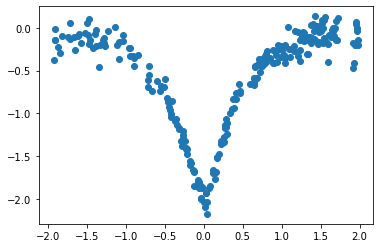

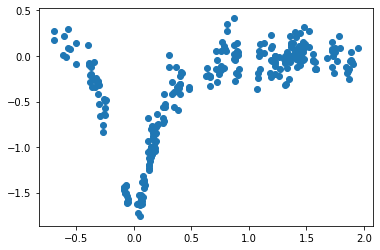

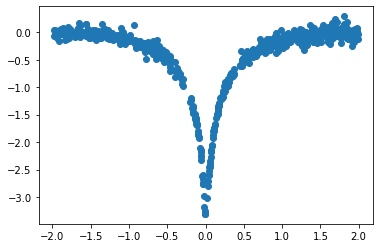

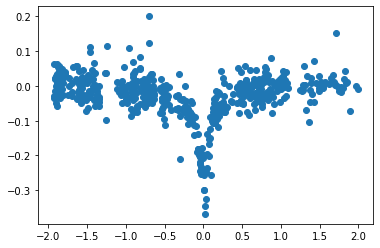

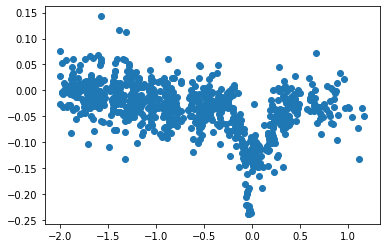

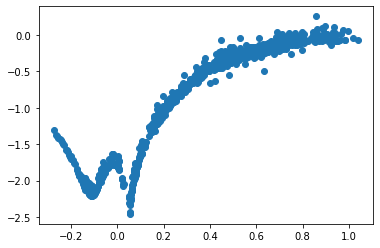

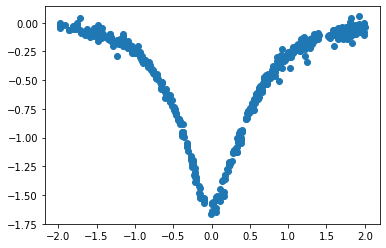

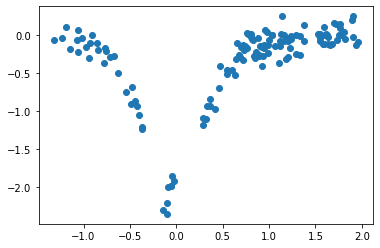

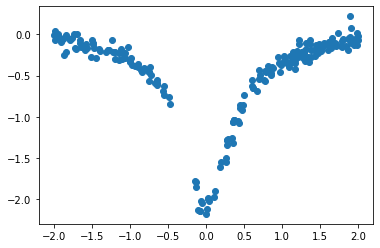

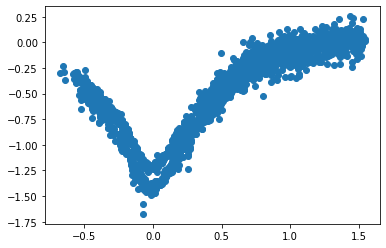

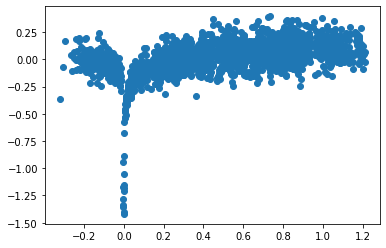

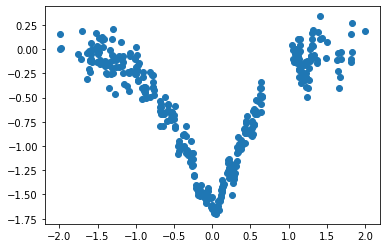

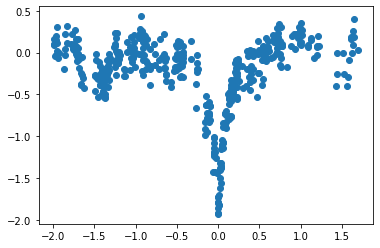

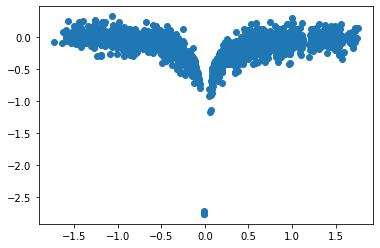

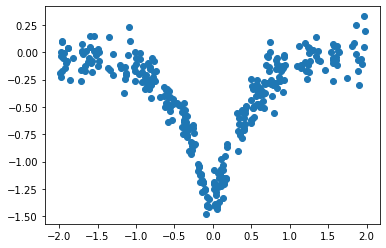

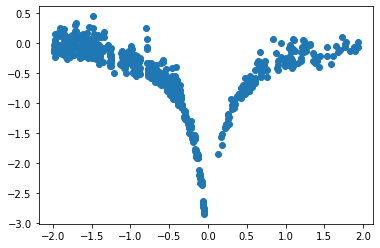

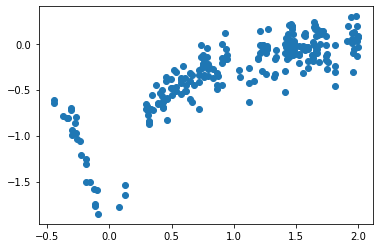

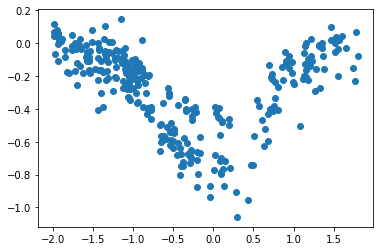

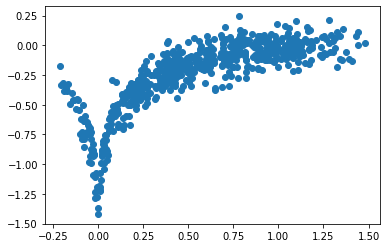

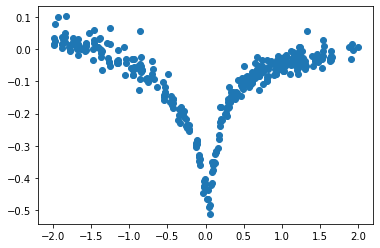

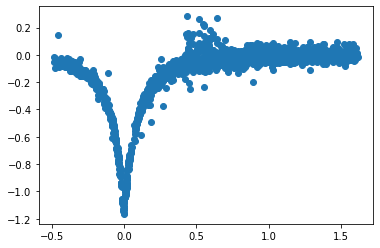

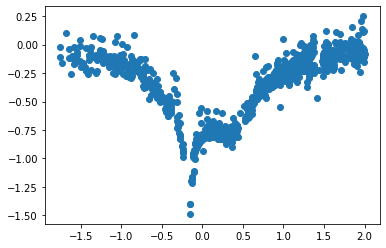

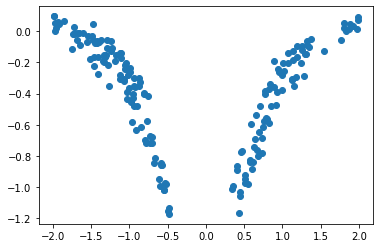

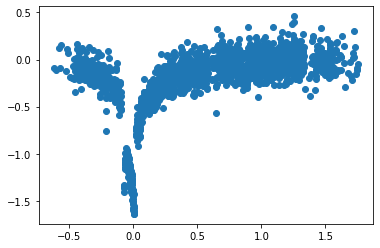

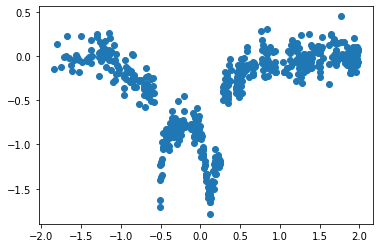

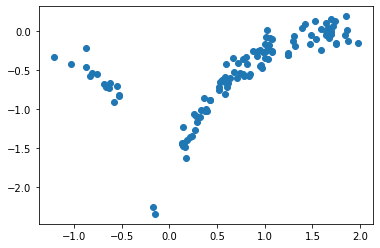

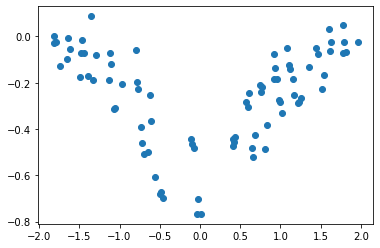

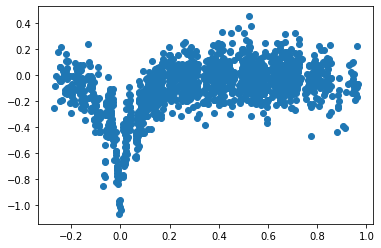

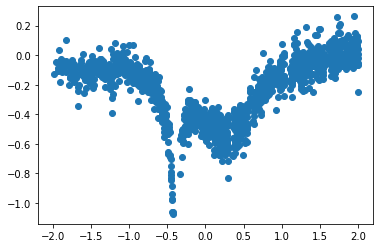

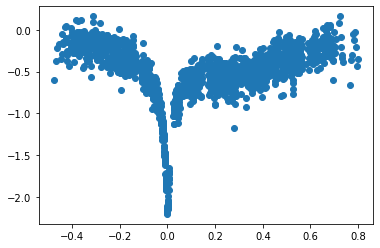

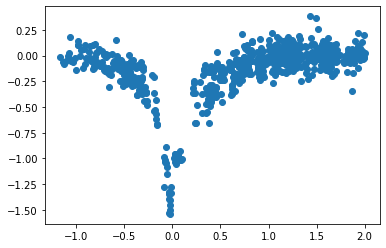

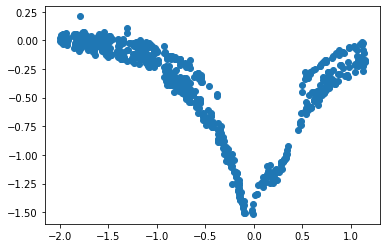

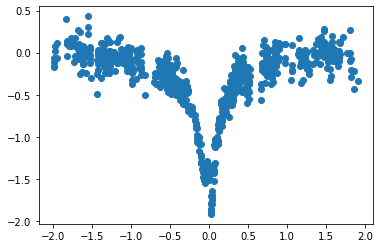

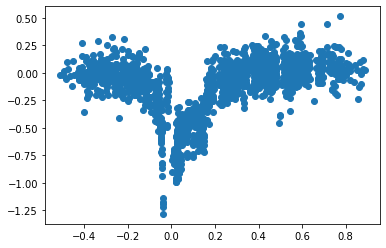

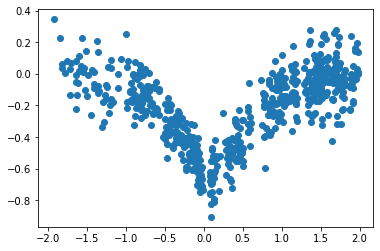

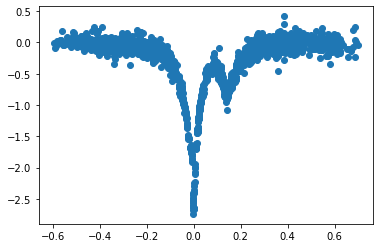

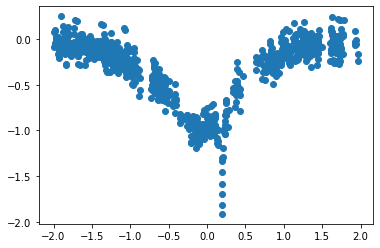

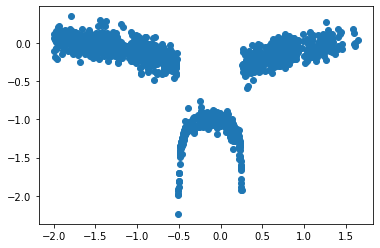

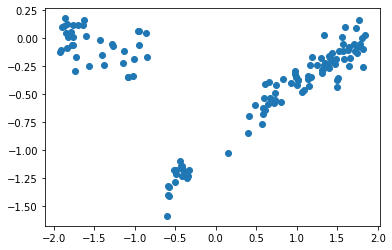

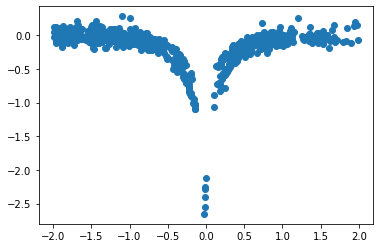

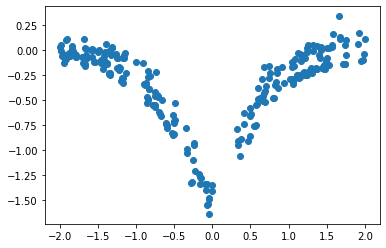

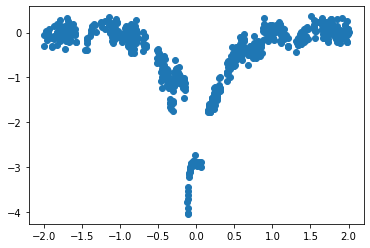

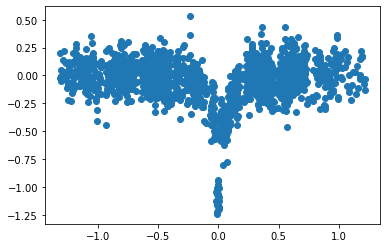

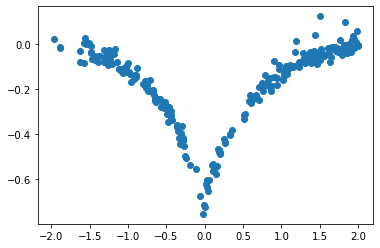

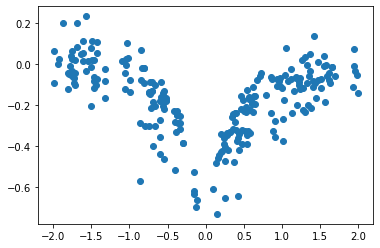

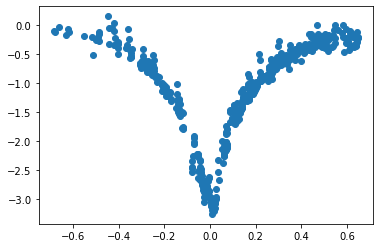

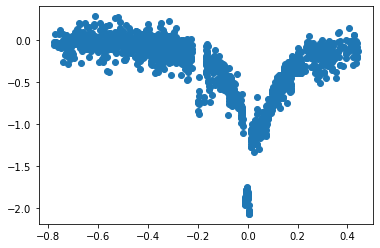

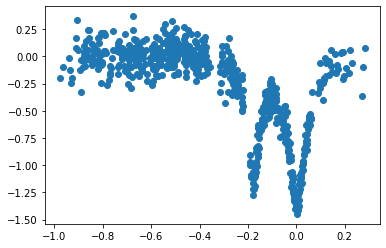

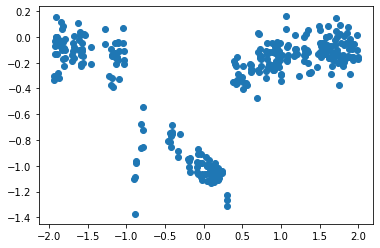

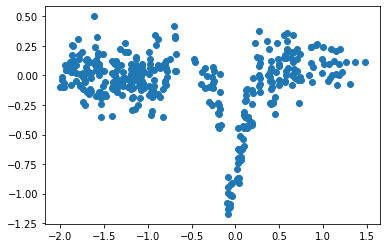

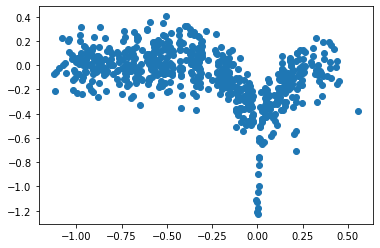

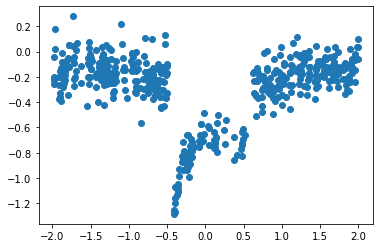

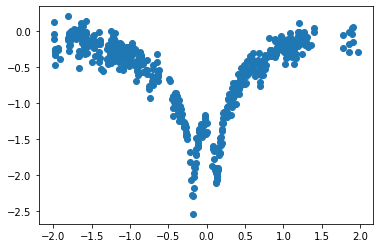

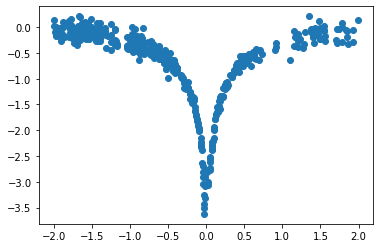

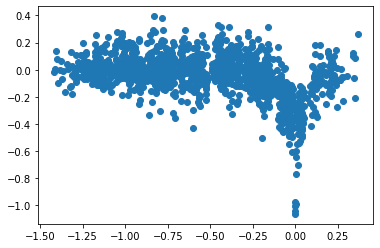

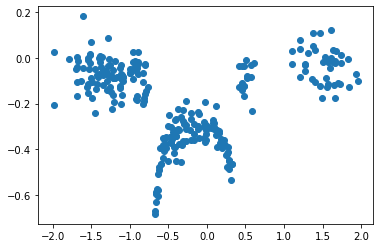

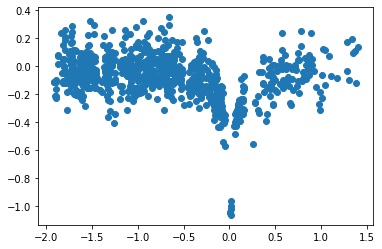

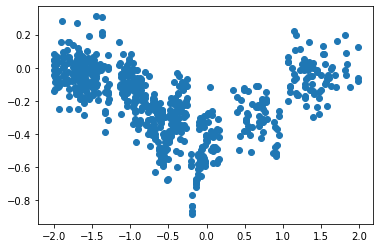

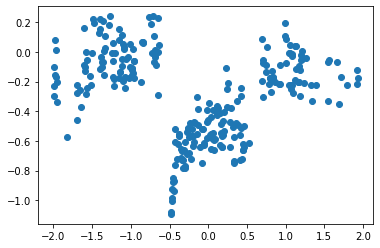

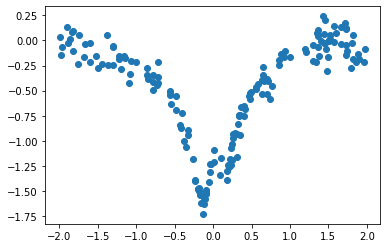

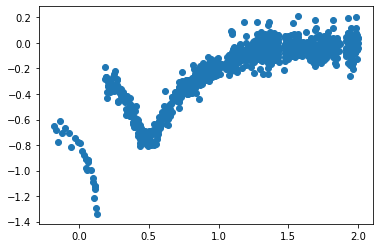

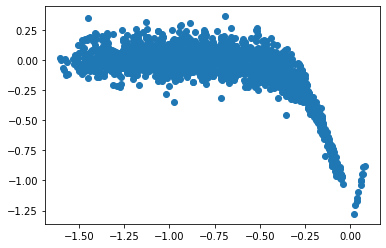

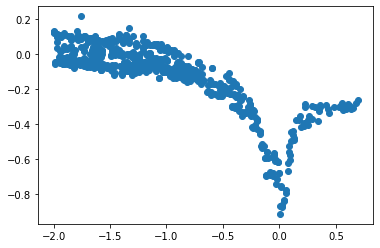

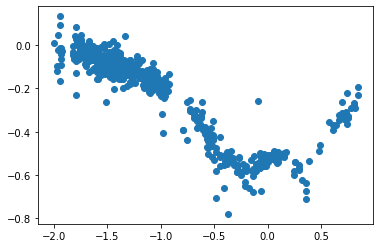

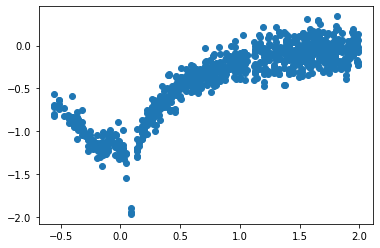

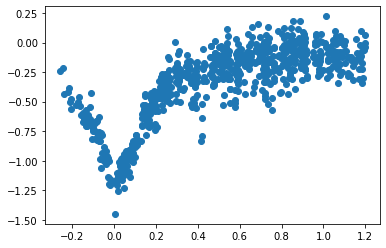

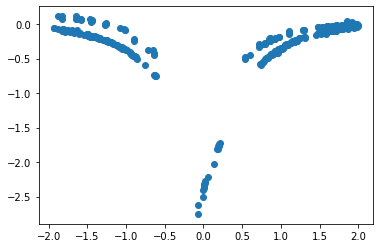

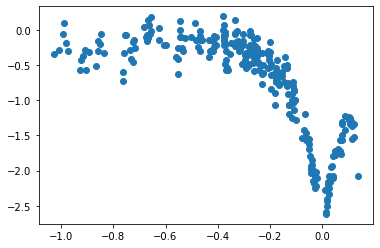

  0%|          | 0/68 [00:00<?, ?it/s]

In [6]:
max_len = 0
lc = []
fs_list = []
for i in tqdm(range(len(eventid_list))):
    data = []
    for root, dirs, files in os.walk(targetdir + 'KMT-2019-BLG-' + eventid_list[i]):
        for f in files:
            if 'V' not in f:
                p = re.compile('___')
                file = open(f'{targetdir}KMT-2019-BLG-{eventid_list[i]}/{f}', 'r+')
                lines = [line for line in file.readlines() if p.search(line) is None]
                file.seek(0)
                file.truncate(0)
                file.writelines(lines)
                file.close()

                data.append(np.loadtxt(f'{targetdir}KMT-2019-BLG-{eventid_list[i]}/{f}'))
    data = np.vstack(data)
    data = data[np.argsort(data[:, 0])]

    # preprocess
    t0 = params[i, 0]; te = params[i, 1]; Ibase = params[i, -1]
    # print(t0, te, Ibase)

    # filter
    data = np.delete(data, np.where(data[:, 5] > 6.5), axis=0)
    data = np.delete(data, np.where(data[:, 5] < 0), axis=0)
    data = np.delete(data, np.where(data[:, 4] > data[:, 3] / 100), axis=0)
    # data = np.delete(data, np.where(data[:, 6]<1000), axis=0)
    for j in range(10):
        data = np.delete(data, np.where((np.abs(np.diff(data[:, 3])) > 0.3)), axis=0)

    # Ibase
    if len(data[np.abs(data[:, 0] - t0) > 0.3 * 4 * te][:, 3]) == 0:
        m0 = Ibase
    else:
        m0 = data[np.abs(data[:, 0] - t0) > 0.3 * 4 * te][:, 3].mean()
    data[:, 3] = data[:, 3] - m0

    # # fs
    # t_scaled = (data[:, 0] - t0) / te
    # plt.scatter(t_scaled, data[:, 3])
    # plt.show()
    # x = torch.tensor(np.stack([t_scaled, data[:, 3]], axis=-1)).unsqueeze(0)
    # depth = 2; window_length = 1; 
    # train_logsig = torchcde.logsig_windows(x, depth, window_length=window_length)
    # train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
    # fs = 10**(model_s(train_coeffs.float().to(device)).detach().cpu().item())
    # print(fs)
    # fs_list.append(fs)

    # data[:, 3] = - 2.5 * np.log10(flux * fs + 1 - fs) / 0.2

    # data[:, 3] = (data[:, 3] - 14.5) / 0.2

    # time rescale
    data = data[(data[:, 0] > t0 - 2 * te) * (data[:, 0] < t0 + 2 * te)]
    data[:, 0] = (data[:, 0] - t0) / te
    plt.scatter(data[:, 0], data[:, 3])
    plt.show()
    data = torch.tensor(data[:, [0, 3]]).unsqueeze(0)
    depth = 3; window_length = max(data.shape[-2]//100, 1)
    data = torchcde.logsig_windows(data, depth, window_length=window_length).squeeze(0)
    max_len = max(max_len, data.shape[-2])
    lc.append(data)

data = torch.zeros(len(eventid_list), max_len, data.shape[-1])
for i in tqdm(range(len(eventid_list))):
    data[i] = torch.cat([lc[i], lc[i][-1].expand(max_len - len(lc[i]), lc[i].shape[-1])])

with h5py.File(targetdir + 'processed_data.h5', mode='w') as dataset_file:
    dataset_file['X'] = data

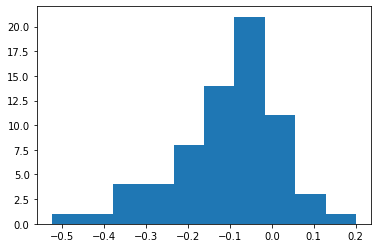

In [18]:
plt.hist(np.log10(fs_list))
plt.show()

In [19]:
eventid_list[18], fs_list[18]

('0021', 1.03561828919829)

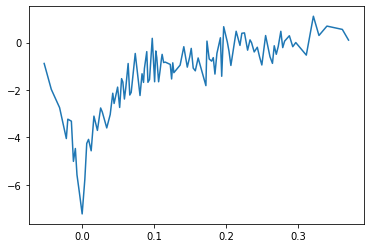

In [20]:
plt.plot(data[18, :, 0], data[18, :, 1])